# End to End Time Series With SARIMA: Johnson&Johnson

We will use the Johnson & Johnson quaterly earnings data as another illustrating example of forecasting with Seasonal Auto Regressive Moving Average **SARIMA**. This dataset is avaiable in the [R datasets package](https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/00Index.html). 

**SARIMA** models can be written as **SARIMA(p,d,q, P, D, Q, S)**. To fit a time series, we need to determine the parameters **p,d,q, P, D, Q, S** (we will explain later what these parameters mean) and  the following checklist can be useful:

- **Make a plot of the series**  
This will help identify trends or seasonality and provide a sense of what the data and if transformation are needed  

- **Perform need transformations**   
Usually if the series is not stationary because of non-contant variance or trends, we need to perform a transformation (e.g. log transform) to make is stationary   

- **Perform differencing**  
This will help identify the order of differencing needed to remove trends or seasonality. See this [post](https://machinelearningmastery.com/difference-time-series-dataset-python/) or [this](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/) for examples.   

- **Ljung-Box Test**  
Can we use to check if there is autocorrelations between observations at different time lags

- **Make ACF plots**   
Can be used to determine the orders of parameters for the MA components
- closer significant spikes determine the order p of non-seasonal MA
- significant spikes around seasonal lag determine the order of seasonal MA

- **Make PACF plots**   
Can be used to determine the orders of parameters for the AR components
- closer significant spikes determine the order p of non-seasonal AR
- significant spikes around seasonal lag determine the order of seasonal AR

Let's get started.

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import datetime
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Load The Data

Loading the Johnson & Johnon quaterly earnings data. The data goes from 1960 to 1980, each row representing a year.

In [2]:
df = pd.read_csv("data/JohnsonJohnson.csv", parse_dates=['year'])
df.tail()

,year,Qtr1,Qtr2,Qtr3,Qtr4
16,1976-01-01,7.74,8.91,8.28,6.84
17,1977-01-01,9.54,10.26,9.54,8.73
18,1978-01-01,11.88,12.06,12.15,8.91
19,1979-01-01,14.04,12.96,14.85,9.99
20,1980-01-01,16.20,14.67,16.02,11.61


# Data Transformation

Let's tranform the data by colapsing the different quarters into additional rows. We can add rows as follows
- Qrt1 - January
- Qtr2 - April
- Qrt3 - July
- Qrt4 - October

So we need to create a date range going from 1960 to 1980. The length should be 4 times the length of the original dataframe. We will make the frequency be equal to 3 months

In [3]:
#collapse the data by adding 4 row for each year
Qtr = []
for i in df.index:
    Qtr +=[
        df.loc[i, 'Qtr1'],
        df.loc[i, 'Qtr2'], 
        df.loc[i, 'Qtr3'], 
        df.loc[i, 'Qtr4']      
    ]

#create indices going from 1960 to 1980. 
index = pd.date_range('1/1/1960', periods=4*len(df), freq='3M')
y = pd.DataFrame(Qtr, index=index, columns=['Earnings'])
y.index.name = 'Date'
index

DatetimeIndex(['1960-01-31', '1960-04-30', '1960-07-31', '1960-10-31',
               '1961-01-31', '1961-04-30', '1961-07-31', '1961-10-31',
               '1962-01-31', '1962-04-30', '1962-07-31', '1962-10-31',
               '1963-01-31', '1963-04-30', '1963-07-31', '1963-10-31',
               '1964-01-31', '1964-04-30', '1964-07-31', '1964-10-31',
               '1965-01-31', '1965-04-30', '1965-07-31', '1965-10-31',
               '1966-01-31', '1966-04-30', '1966-07-31', '1966-10-31',
               '1967-01-31', '1967-04-30', '1967-07-31', '1967-10-31',
               '1968-01-31', '1968-04-30', '1968-07-31', '1968-10-31',
               '1969-01-31', '1969-04-30', '1969-07-31', '1969-10-31',
               '1970-01-31', '1970-04-30', '1970-07-31', '1970-10-31',
               '1971-01-31', '1971-04-30', '1971-07-31', '1971-10-31',
               '1972-01-31', '1972-04-30', '1972-07-31', '1972-10-31',
               '1973-01-31', '1973-04-30', '1973-07-31', '1973-10-31',
      

In [4]:
y.head()

,Earnings
Date,
1960-01-31,0.71
1960-04-30,0.63
1960-07-31,0.85
1960-10-31,0.44
1961-01-31,0.61


In [5]:
y.tail()

,Earnings
Date,
1979-10-31,9.99
1980-01-31,16.20
1980-04-30,14.67
1980-07-31,16.02
1980-10-31,11.61


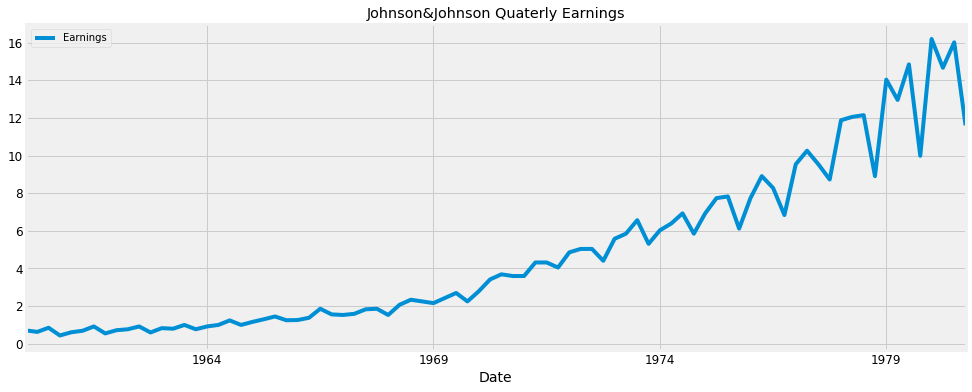

In [6]:
_ = y.plot(figsize=(15, 6), title='Johnson&Johnson Quaterly Earnings')

# Series Decomposition

We can use a time-series decomposition method to decompose our time series into three distinct components: 
- Trend 
- Seasonality
- Noise

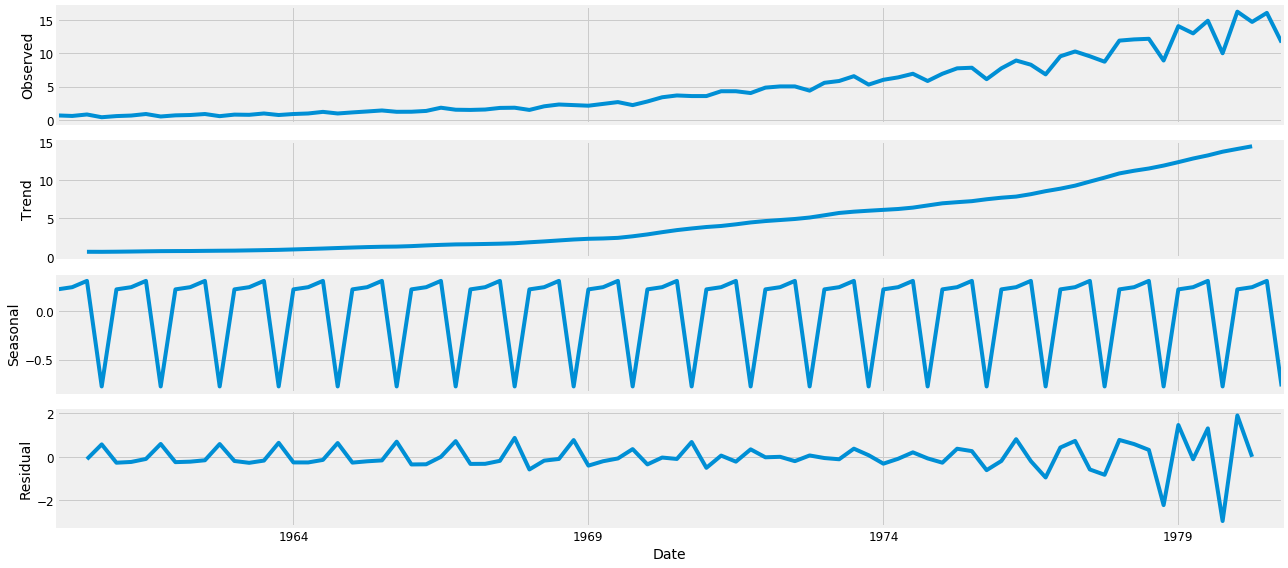

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

The plot clearly shows that sales data is not stationary. 
- There is a clear trend, earnings have been increasing over the years. **We will need to perform differencing.**
- There is seasonality, quite consistent across years. We already know the frequency is 4 but we will see how to estimate it later
- Noise term seems to have different variance, **we will need to perform a transformation** 


# Look at ACF and PACF

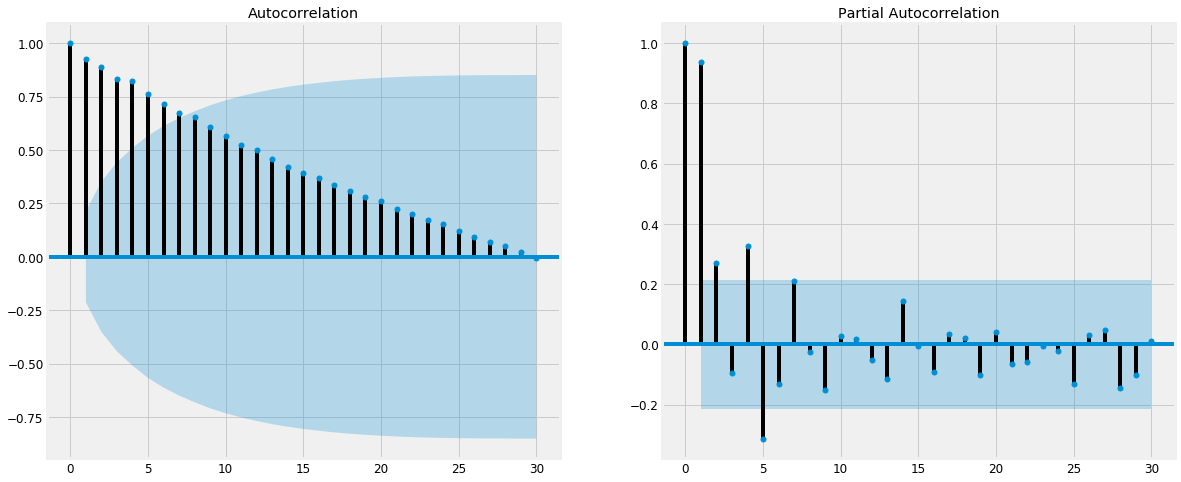

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot_acf(y, lags=30, ax=ax1)
ax2 = fig.add_subplot(122)
plot_pacf(y, lags=30, ax=ax2)
plt.show()

- The ACF decays very slowing. This i usually an indication that differencing is needed
- From the PACF, we can infer that the seasonal period S=4 and we are looking at maybe AR(1) model

# Tranforming the data to make the series stationary

In [9]:
#first a log transform to make the variance constant
logy = np.log(y)

#Then differencing to remove trends
dlogy = logy.diff(periods=1).dropna()

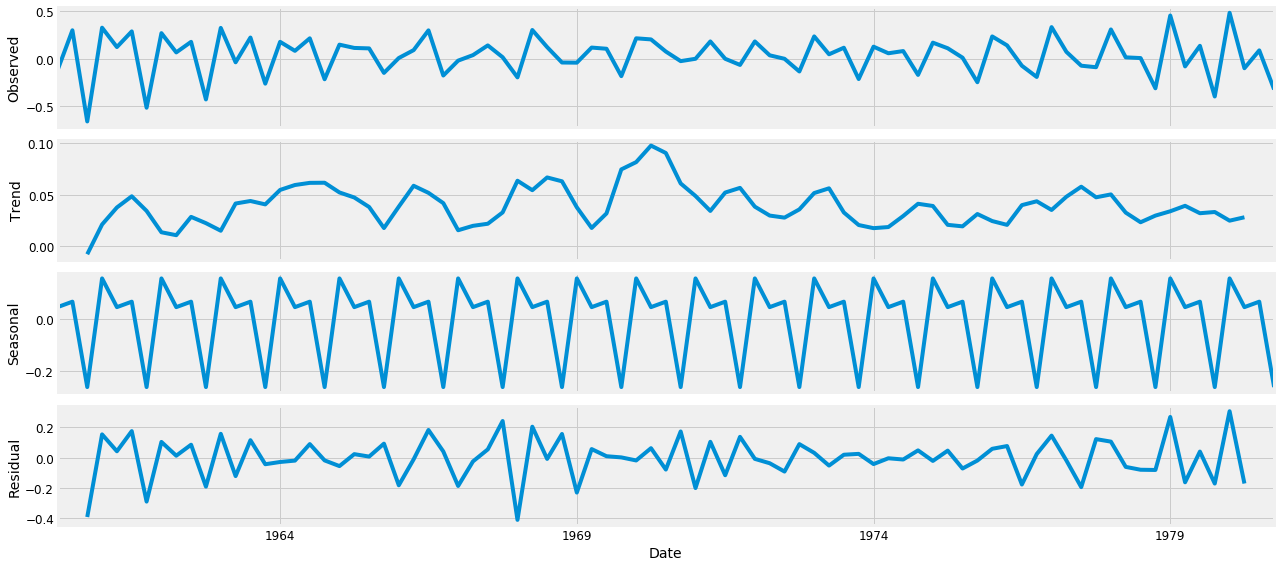

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(dlogy, model='additive')
fig = decomposition.plot()

- Now the time series appears more or less stationay
- The systematic trend has been removed
- The residuals still show non constant variance, but it's better than before.  

# Fitting with SARIMA

We can use a classic method for time series analysis **SARIMA** which stands for Seasonal Auto Regressive Integrated Moving Average. **SARIMA** models are written **SARIMA$(p, d, q, P, D, Q)_S$** where 

- **p** is the order of the Auto Regressive component (how the past affects the present)
- **d** is the order of the difference needed to remove systematic trends in the data
- **q** is the order of the Moving Average component (noise effects, what we don't know)
- **P, D, Q** are equivalent order for the seasonal effects.   

So the question is how do we determine p, d, q, P, D, Q? 

## Develop Intuition of the orders using ACF and PACF

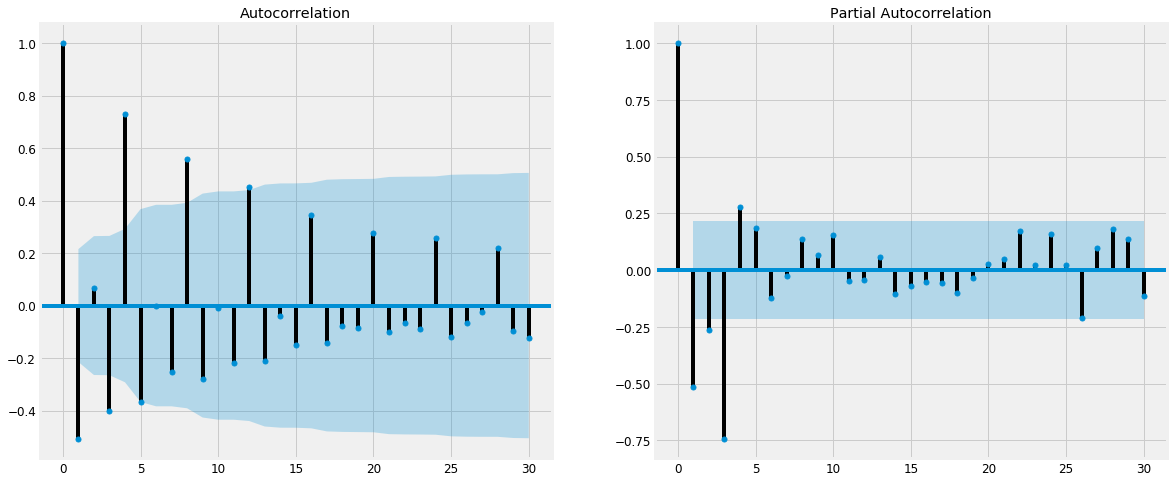

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot_acf(dlogy, lags=30, ax=ax1)
ax2 = fig.add_subplot(122)
plot_pacf(dlogy, lags=30, ax=ax2)
plt.show()

**From the Autocorrelation Plot ACF**  
- We can infer a cut-off structure after lag 1 in the non-seasonal MA part (possible q = 0, 1)
- The seasonal MA part shows a decay pattern. perhaps Q = 0? (we need to look at the PACF plot to decide)
- The slow decay in the seasonal component also suggest that we need some seasonal differencing, i.e D = 1 ?
- Seasonal period S = 4

**From the Partial Autocorrelation Plot ACF** 
- We see a cut-off structure in the non-seasonal part with about 2 significant lags (suggest p = 0,1,2)
- The seasonal AR part also show a cut-off structure which dies off after about 2 periods (possible P = 0,1,2)

**How do we determine d?**  
- We needed to take the first order difference to remove the trend, so d=1 
- The slow decay in the seasonal part shown in the ACF plot suggests that maybe D=1

**Apply The Parsimony Principle**   
The idea here is that we should use the simplest possible model that best fits the data. The rule goes like this:

$$p + d + q + P + D + Q \lt 6$$

**Possible Model from ACF and PACF is SARIMA(p=1, d=1, q=0, P=1, D=1, Q=0, S=4)**

## Use Grid Search?

With the intuition from the ACF and PACF plots, we have a narrow range of parameters to seach. We can also use 
**Grid Search** to find the best model (that minimizes the AIC or SSE)

In [12]:
def grid_search(y, pdq, seasonal_pdq):

    warnings.filterwarnings("ignore")
    aic = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                name = param+param_seasonal
                aic[name] = results.aic
                #print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
print('Finding Best Parameter combinations for Seasonal ARIMA...')

aic = grid_search(logy, pdq, seasonal_pdq)
#get the model with minimum aic : min(dict, key=dict.get) will return the key with minimum value in dict
print("Model with Minimum AIC of {} is {}".format(aic[min(aic, key=aic.get)], min(aic, key=aic.get)))

Finding Best Parameter combinations for Seasonal ARIMA...
Model with Minimum AIC of -157.36883162931383 is (1, 0, 1, 1, 0, 1, 4)


The above output suggests that **SARIMA(1, 0, 1)x(1, 0, 1, 4)** yields the lowest AIC value. Therefore we should consider this to be optimal option.   
We found using ACF and PACF that a possible model can be **SARIMA(1, 1, 0)x(1, 1, 0, 4)**. We can try both but I will go with the second

## Fitting the Model

In [13]:
mod = sm.tsa.statespace.SARIMAX(logy,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5233      0.092     -5.687      0.000      -0.704      -0.343
ar.S.L4       -0.3161      0.115     -2.750      0.006      -0.541      -0.091
sigma2         0.0081      0.002      4.995      0.000       0.005       0.011


The above summary shows that
- The estimated coefficient for the AR component significant since the p-value is small
- The estimated paramter for the MA component is significant
- The estimated stantard deviation of the noise term is significant. 

## Model Diagnostic

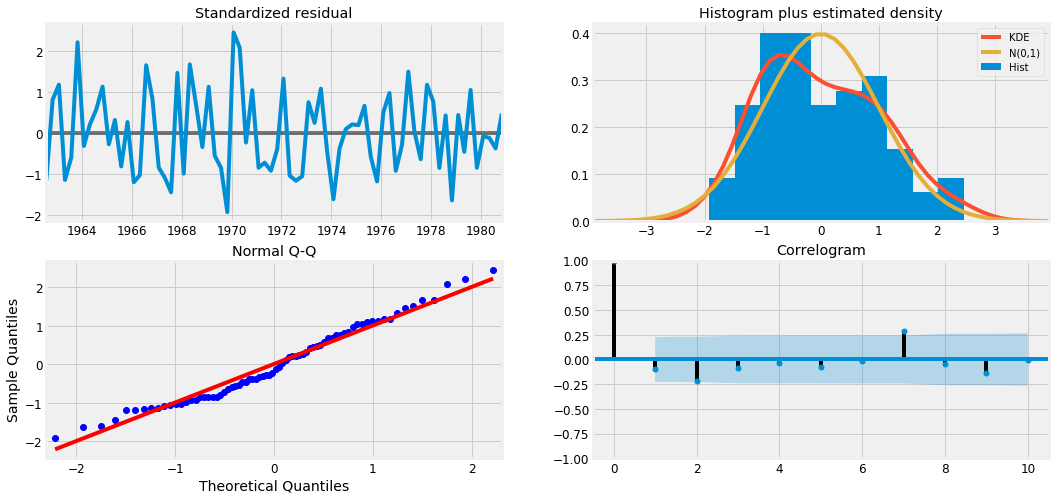

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

What are we looking for in the above plot?
- The residuals need to be normally distributed with mean 0. The first plot seems to support that.
- The histogram also looks like a decent approximation of normal distribution
- The Q-Q plot should be linear, it looks pretty linear
- There should be no correlation between the residuals, the correlogram plot seems to support that


## Validating 

Let do some forecasts starting on 1980-11-01 to the end of the data.

In [15]:
logy.head()

,Earnings
Date,
1960-01-31,-0.342490
1960-04-30,-0.462035
1960-07-31,-0.162519
1960-10-31,-0.820981
1961-01-31,-0.494296


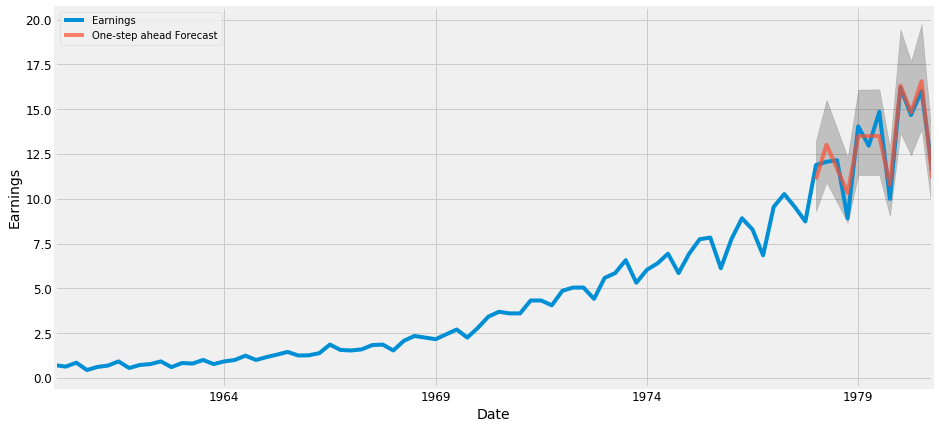

In [16]:
pred = results.get_prediction(start=pd.to_datetime('1978-01-31'), dynamic=False)
pred_ci = pred.conf_int()

e_logy = np.exp(logy)
ax = logy.apply(np.exp)['1960':].plot(label='observed')

pred.predicted_mean.apply(np.exp).plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), 
                color='k', 
                alpha=.2
               )

ax.set_xlabel('Date')
ax.set_ylabel('Earnings')
plt.legend(loc='upper left')
plt.show()

## Evaluation

In [17]:
y_truth = np.exp(logy['1978-01-31':]).values
y_forecasted = np.exp(pred.predicted_mean).values.reshape(y_truth.shape)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Mean = {}, MSE = {}, RMSE = {}'.format(round(y_truth.mean(), 2), round(mse, 2), round(mse**(0.5),2)))

Mean = 12.94, MSE = 0.61, RMSE = 0.78


## Forecasting the Feature

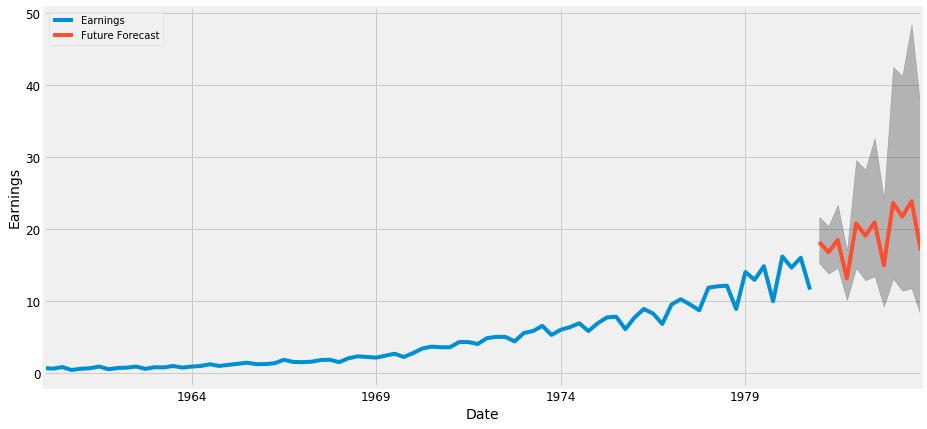

1981-01-31    18.202046
1981-04-30    16.798782
1981-07-31    18.500157
1981-10-31    13.142068
1982-01-31    20.786493
1982-04-30    19.087747
1982-07-31    20.954319
1982-10-31    14.983766
1983-01-31    23.630222
1983-04-30    21.735175
1983-07-31    23.883682
1983-10-31    17.043300
Freq: 3M, dtype: float64

In [18]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(figsize=(14, 7))

pred_uc.predicted_mean.apply(np.exp).plot(ax=ax, label='Future Forecast')
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), 
                color='k', 
                alpha=.25
               )

ax.set_xlabel('Date')
ax.set_ylabel('Earnings')
plt.legend(loc='upper left')
plt.show()
pred_uc.predicted_mean.apply(np.exp)

Not bad! We can make forecast for the next two years. It's obvious that we have less confidence in the forecast as we look further into the future

**Useful Links** 

- [Facebook Prophet](https://research.fb.com/prophet-forecasting-at-scale/)
- [Resampling Time Series](http://benalexkeen.com/resampling-time-series-data-with-pandas/)
- [Prophet with PyMC3](https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/)
- [11 Methods for Time Series Analysis](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)